In [38]:
import torch
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
import torch.nn.functional as F
%matplotlib inline

In [39]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

# Отобразим наш датасет

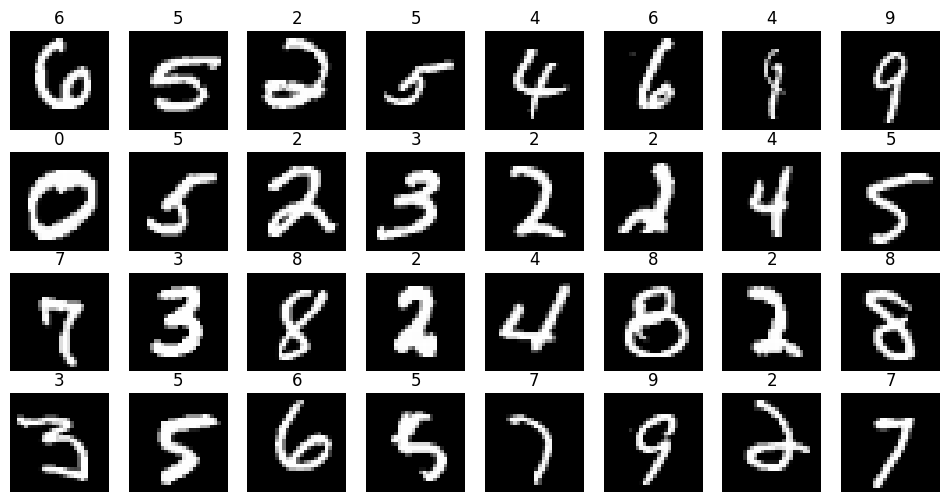

In [41]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Визуалиируем иозбражение с значениями пикселей после нормализации.

In [42]:
def pixel_visualize_torch(data_loader, index=1, batch_index=0):
    """
    Визуализирует изображение из DataLoader с значениями пикселей

    Args:
        data_loader: DataLoader с данными
        index: индекс изображения в батче
        batch_index: индекс батча (если shuffle=True, будет случайный)
    """
    # Получаем батч данных
    images, labels = next(iter(data_loader))

    # Берем конкретное изображение из батча
    img_tensor = images[index].squeeze()  # Убираем dimension канала (1,28,28) -> (28,28)
    label = labels[index].item()

    # ОТМЕНА НОРМАЛИЗАЦИИ - важный шаг!
    # Восстанавливаем оригинальные значения пикселей
    mean = 0.1307
    std = 0.3081
    img_unnormalized = img_tensor * std + mean
    # Конвертируем в numpy и обрезаем до [0,1] на случай выхода за границы
    img_np = torch.clamp(img_unnormalized, 0, 1).numpy()

    # Визуализация
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(img_np, cmap="gray")
    ax.set_title(f'Label: {label}')

    width, height = img_np.shape
    threshold = img_np.max() / 2.5

    # Аннотации значений пикселей
    for x in range(width):
        for y in range(height):
            ax.annotate(f'{img_np[x][y]:.2f}',
                       xy=(y, x),
                       ha='center', va='center',
                       fontsize=8,
                       color='white' if img_np[x][y] < threshold else 'black')

    plt.show()


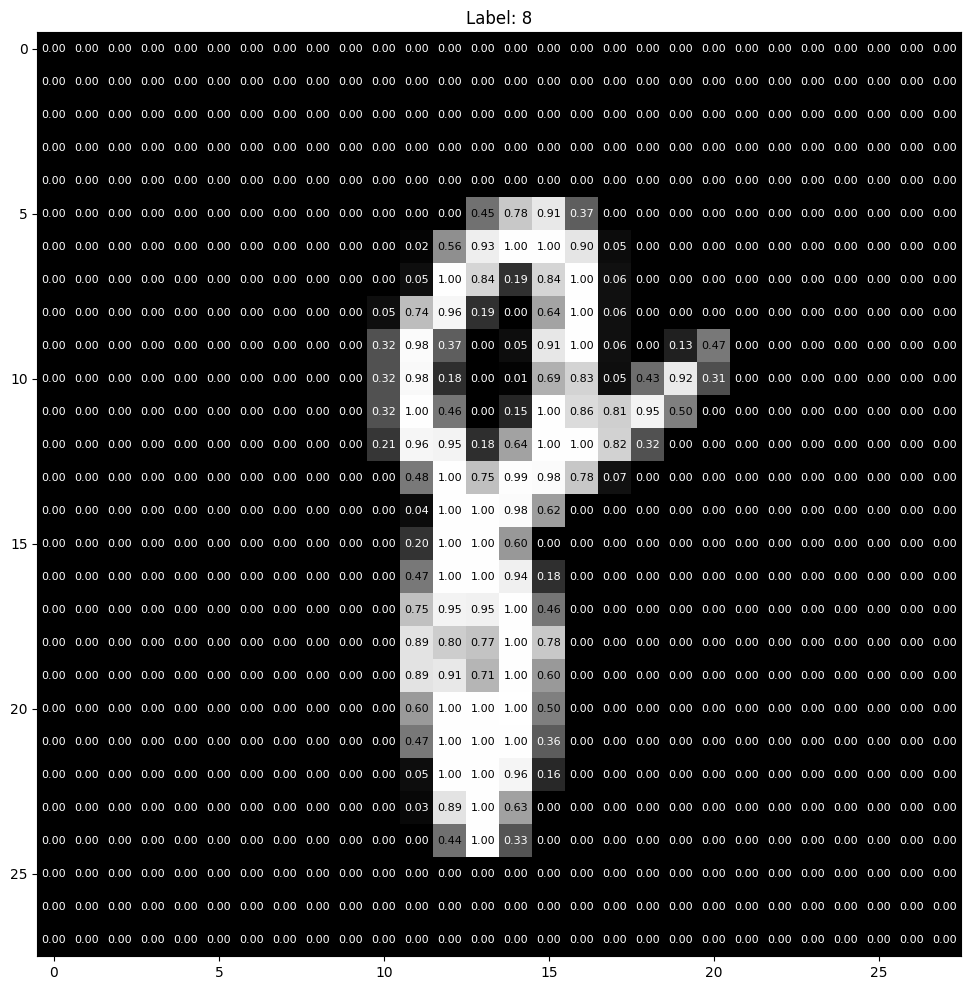

In [43]:
# Использование:
pixel_visualize_torch(train_loader, index=7, batch_index= 2)  # Первое изображение в первом батче

In [48]:
def train(model, optimizer, n_epochs=5, verbose=True):
    loss_list = []
    accuracy_list = []
    iteration_list = []

    count = 0

    for epoch in range(n_epochs):
        model.train()

        for i, (images, labels) in enumerate(train_loader):
            # Прямой проход
            outputs = model(images)
            loss = F.nll_loss(outputs, labels)

            # Обратное распространение
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            count += 1

            # Валидация каждые 50 итераций
            if count % 50 == 0:
                correct = 0
                total = 0

                model.eval()
                with torch.no_grad():
                    for test_images, test_labels in test_loader:
                        test_outputs = model(test_images)
                        predicted = torch.argmax(test_outputs.data, 1)
                        total += test_labels.size(0)
                        correct += (predicted == test_labels).sum().item()

                accuracy = 100 * correct / total

                # Сохраняем метрики
                loss_list.append(loss.item())
                accuracy_list.append(accuracy)
                iteration_list.append(count)

                # Вывод каждые 500 итераций
                if count % 500 == 0 and verbose:
                    print('Iteration: {}  Loss: {:.4f}  Accuracy: {:.2f} %'.format(
                        count, loss.item(), accuracy))

                model.train()  # Возвращаем в режим обучения

    if verbose:
        print(f'Training completed! Total iterations: {count}')

    return loss_list, accuracy_list, iteration_list

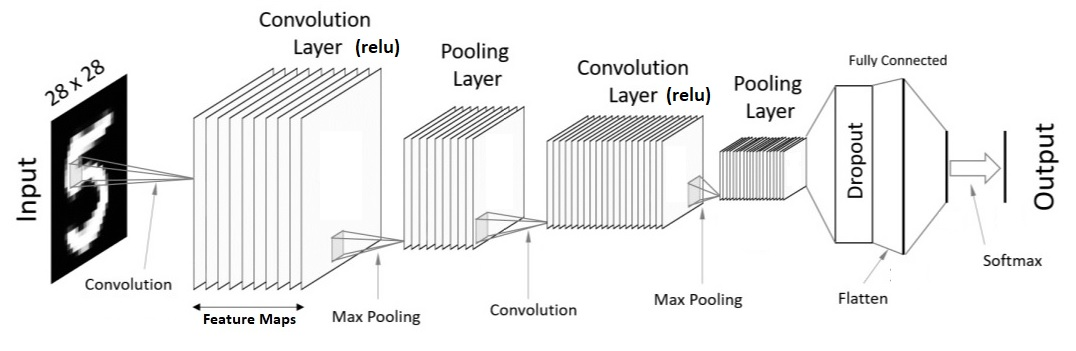

Обучим CNN с одним сверточным и pooling слоями. На выходе будем преобразовывать в вектор и использовать функцию активации ReLU. В качестве ошибки будем использовать NLLLos() и для этого будем преобразовывать выход с помощью softmax.


In [49]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
loss_list, accuracy_list, iteration_list = train(model, optimizer, n_epochs=5)


Iteration: 500  Loss: 0.0661  Accuracy: 94.49 %
Iteration: 1000  Loss: 0.1588  Accuracy: 96.06 %
Iteration: 1500  Loss: 0.1622  Accuracy: 96.85 %
Iteration: 2000  Loss: 0.1359  Accuracy: 97.35 %
Iteration: 2500  Loss: 0.0076  Accuracy: 97.71 %
Iteration: 3000  Loss: 0.0039  Accuracy: 98.14 %
Iteration: 3500  Loss: 0.0039  Accuracy: 97.98 %
Iteration: 4000  Loss: 0.0140  Accuracy: 98.28 %
Iteration: 4500  Loss: 0.0108  Accuracy: 98.38 %
Iteration: 5000  Loss: 0.0180  Accuracy: 98.26 %
Iteration: 5500  Loss: 0.0062  Accuracy: 98.27 %
Iteration: 6000  Loss: 0.0441  Accuracy: 98.44 %
Iteration: 6500  Loss: 0.0107  Accuracy: 98.51 %
Iteration: 7000  Loss: 0.2028  Accuracy: 98.82 %
Iteration: 7500  Loss: 0.0146  Accuracy: 98.80 %
Iteration: 8000  Loss: 0.0036  Accuracy: 98.77 %
Iteration: 8500  Loss: 0.0638  Accuracy: 98.37 %
Iteration: 9000  Loss: 0.0107  Accuracy: 98.65 %
Training completed! Total iterations: 9375


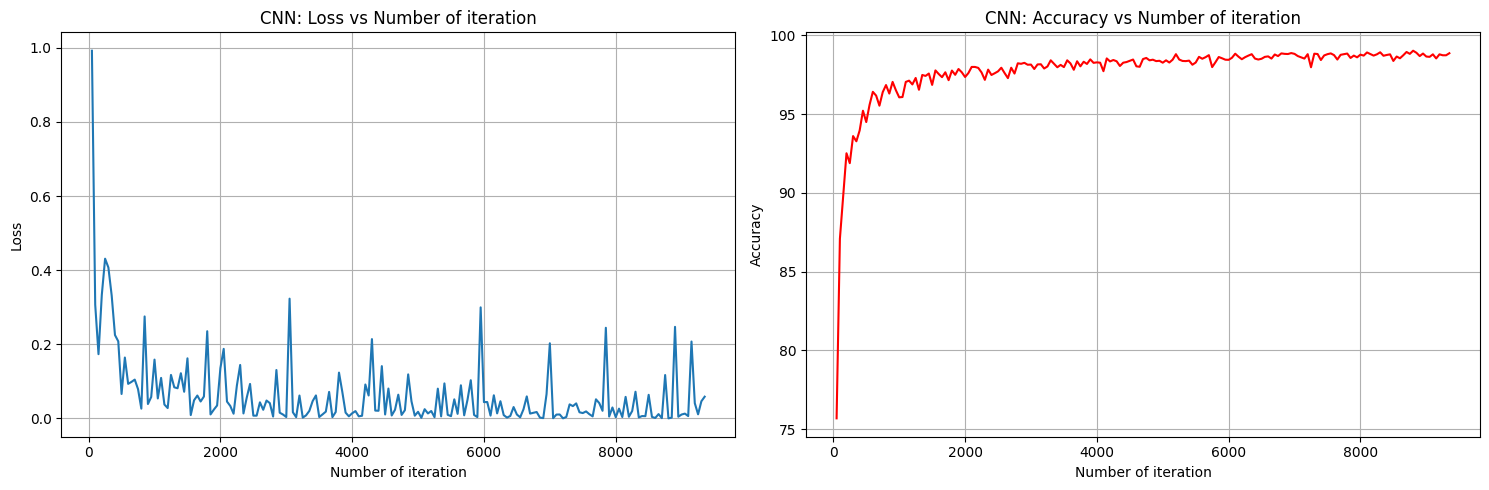

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.grid(True)

plt.tight_layout()
plt.show()

В ходе обчения модели была получена accuracy = 0.9865. Также с помощью нелинейного понижения размерности с помощью tsne можно посмотреть как расположен кластера и где модель ошибается.

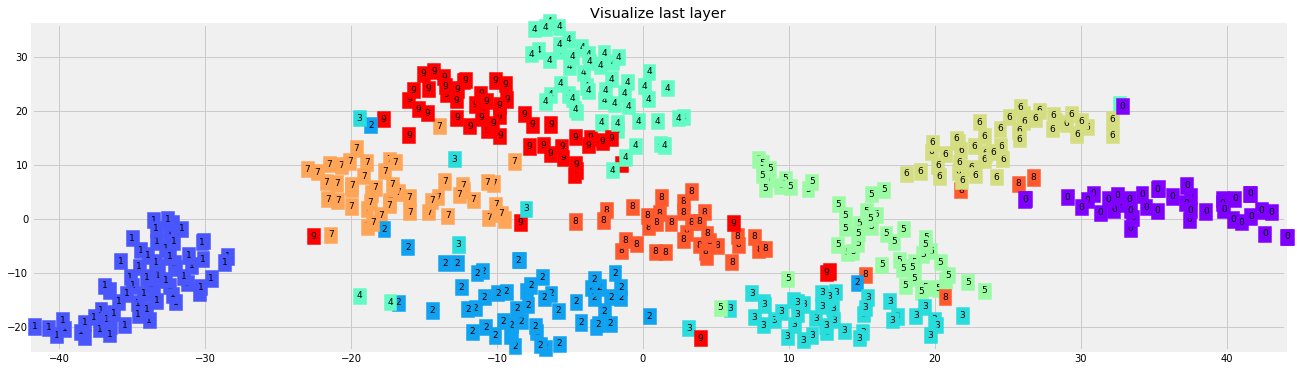